In [1437]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from importlib import reload
import utils, VAE, utils_2
reload(utils)
reload(utils_2)
reload(VAE)
from utils import *
from utils_2 import *
from VAE import VAE


In [1438]:
checkpoint = torch.load('VAE.pth', map_location='cpu', weights_only=False)
args = checkpoint['model_args']
vae = VAE(**args)
vae.load_state_dict(checkpoint['state_dict'])
vae.eval()

VAE(
  (encoder): Encoder(
    (activation): Tanh()
    (linears): ModuleList(
      (0): Linear(in_features=200, out_features=100, bias=True)
      (1): Linear(in_features=100, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=32, bias=True)
    )
    (mu): Linear(in_features=32, out_features=4, bias=True)
    (logvar): Linear(in_features=32, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (activation): Tanh()
    (linears): ModuleList(
      (0): Linear(in_features=4, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=100, bias=True)
      (3): Linear(in_features=100, out_features=200, bias=True)
    )
  )
)

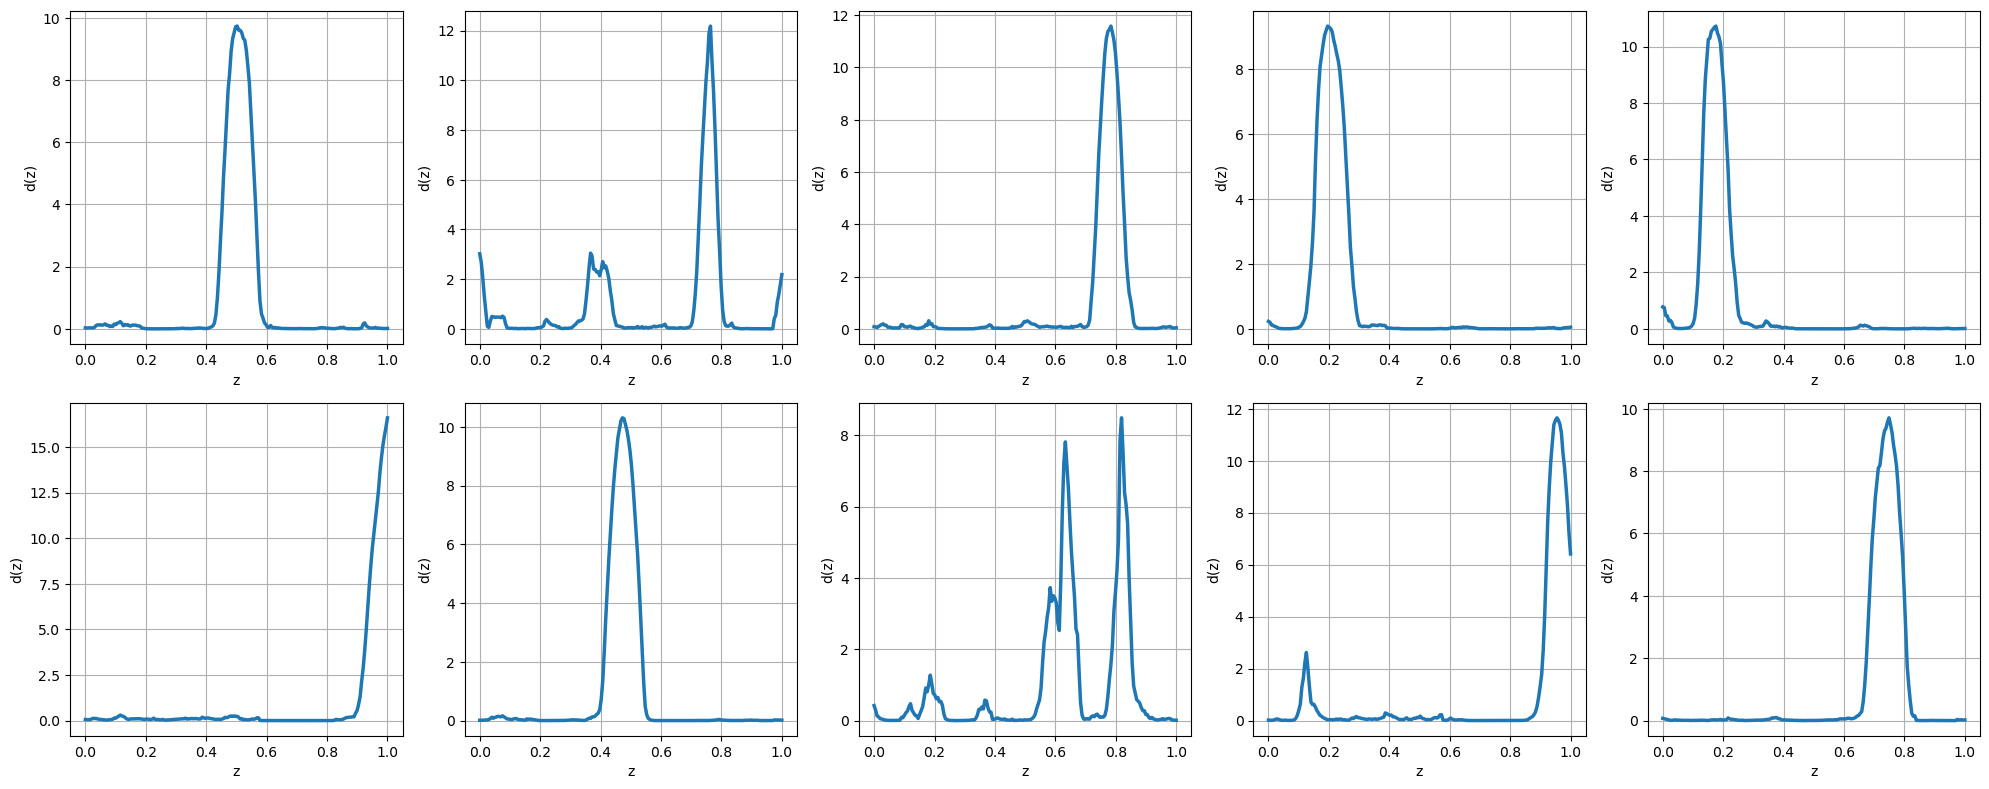

In [1439]:
torch.manual_seed(42)

grid = np.linspace(0, 1, Nz)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

eps = torch.randn(10, 4)

d = vae.decoder(eps).detach().numpy()

#d = generate_leaks(grid, num_leaks=10, random_state=42).detach().numpy()


for j, ax in enumerate(axes):
    ax.plot(grid, d[j,:], label=f"Sample {j+1}", linewidth=2.5)
    ax.set_xlabel("z")
    ax.set_ylabel("d(z)")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
q0 = lambda t : 1 + 0.1 * np.sin(2 * np.pi * t / 10)
pl = lambda t : 1e5 * ( 1 + 0.1 * np.sin(0 * np.pi * t / 10) )

zeros = lambda t : np.sin(0 * t)

X_val = 0.1

sol_0 = solve(q0=q0, pl=pl, d=d[0,:], X=0)

print(sol_0.y.shape)

q = np.stack((sol_0.y[0,:], sol_0.y[Nz-1,:]), axis=0)
p = np.stack((sol_0.y[Nz,:], sol_0.y[-1,:]), axis=0)

y = np.stack((q, p), axis=-1)

y = torch.tensor(y, dtype = torch.float32)

t = sol_0.t


ys0, ysd = [], []
for i in range(10):
    sol_d = solve(q0=q0, pl=pl, d=d[i,:], X=X_val)
    ys0.append(sol_0.y)
    ysd.append(sol_d.y)
    
y0 = np.stack(ys0)
yd = np.stack(ysd)

(400, 50)


In [1441]:
ql0 = y0[:,Nz-1,:].T
q00 = q0(t)
p00 = y0[:,Nz,:].T
pl0 = pl(t)
qld = yd[:,Nz-1,:].T
p0d = yd[:,Nz,:].T

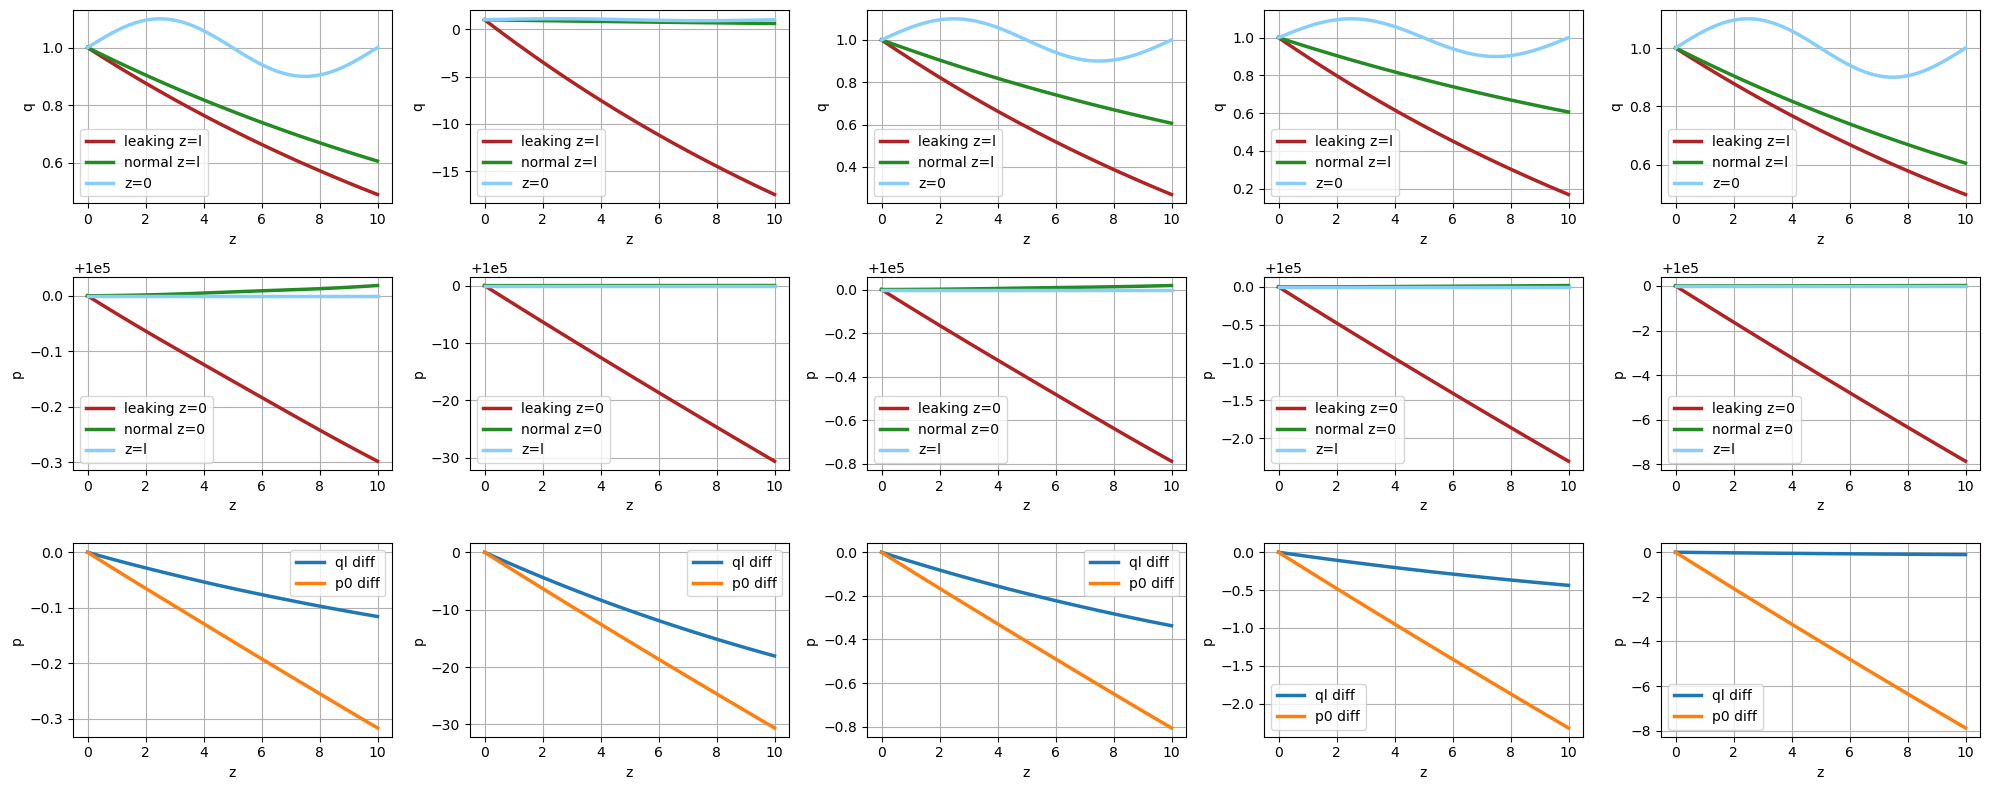

In [1444]:
torch.manual_seed(42)

grid = np.linspace(0, 1, 200)

fig, axes = plt.subplots(3, 5, figsize=(20, 8))

eps = torch.randn(10, 4)

d = vae.decoder(eps).detach().numpy()

for i in range(5):
    axes[0][i].plot(t, qld[:,i], label=f"leaking z=l", linewidth=2.5, color='firebrick')
    axes[0][i].plot(t, ql0[:,i], label=f"normal z=l", linewidth=2.5, color='forestgreen')
    axes[0][i].plot(t, q00, label=f"z=0", linewidth=2.5, color='lightskyblue')
    axes[0][i].set_xlabel("z")
    axes[0][i].set_ylabel("q")
    axes[0][i].grid(True)
    axes[0][i].legend()
    
    axes[1][i].plot(t, p0d[:,i], label=f"leaking z=0", linewidth=2.5, color='firebrick')
    axes[1][i].plot(t, p00[:,i], label=f"normal z=0", linewidth=2.5, color='forestgreen')
    axes[1][i].plot(t, pl0, label=f"z=l", linewidth=2.5, color='lightskyblue')
    axes[1][i].set_xlabel("z")
    axes[1][i].set_ylabel("p")
    axes[1][i].grid(True)
    axes[1][i].legend()
    
    axes[2][i].plot(t, qld[:,i]-ql0[:,i], label=f"ql diff", linewidth=2.5)
    axes[2][i].plot(t, p0d[:,i]-p00[:,i], label=f"p0 diff", linewidth=2.5)
    axes[2][i].set_xlabel("z")
    axes[2][i].set_ylabel("p")
    axes[2][i].grid(True)
    axes[2][i].legend()

plt.tight_layout()
plt.show()

In [1443]:
net = DeepONet([42, 42, 42], [42, 42, 42], K=5, activation='tanh')

#trunk = trunk2([96, 96, 96], K=3, N=50, activation='tanh')
model = Model(net, vae.decoder)
model.train(iterations=10000, val_interval=10)

step       loss       r1          r2
10         6.75e+00   3.74e+00   3.01e+00       


KeyboardInterrupt: 

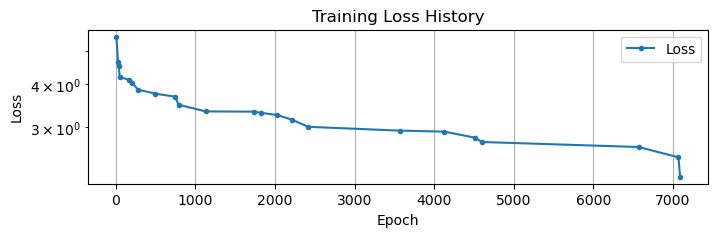

In [ ]:
model.plot_losshistory()

In [ ]:
# output = model.net(model.zt)
# output = output.reshape(Nz, Nt, -1)                      
# y_pred = torch.stack([output[0,...], output[-1,...]], dim=0).detach().numpy()


# fig, ax = plt.subplots(2,2, figsize=(10, 4), sharex=True)

# for i in range(2):
#     for j in range(2):
        
        
#         ax[i][j].plot(t_eval, y_pred[i,...,j])
#         ax[i][j].plot(t_eval, y[i,...,j])

In [ ]:
zt = torch.cartesian_prod(torch.tensor([L], dtype=torch.float32), torch.tensor(t_eval,dtype=torch.float32))

X = torch.tensor([X_val], dtype=torch.float32)
n = X.shape[0]
X_expanded = X[-1,None].repeat_interleave(model.Neps).unsqueeze(1)
eps_expanded = eps.repeat(n, 1)
epsX = torch.cat([X_expanded, eps_expanded], dim=1)

output = model.net(zt, epsX)

i = 8

ql_diff = output[0,:,:,0].detach().numpy()
p0_diff = output[0,:,:,1].detach().numpy()

In [ ]:
ql_error_syn = np.abs(ql0 + ql_diff - qld).sum(0) / (Nz-1)
ql_error_org = np.abs(ql0 - qld).sum(0) / (Nz-1)
ql_norm = np.abs(qld).sum(0) / (Nz-1)

p0_error_syn = np.abs(p00 + p0_diff - p0d).sum(0) / (Nz-1)
p0_error_org = np.abs(p00 - p0d).sum(0) / (Nz-1)
p0_norm = np.abs(p0d).sum(0) / (Nz-1)

print(ql_error_syn / ql_norm)
print(p0_error_syn / p0_norm)

[0.58943046 0.5553895  0.50783093 0.69765531 0.70627656 0.56335463
 0.59820218 0.5035163  0.51593438 0.63365063]
[0.09133672 0.05090756 0.05673985 0.07341884 0.07429882 0.05328917
 0.05882384 0.04859971 0.05467493 0.07231568]


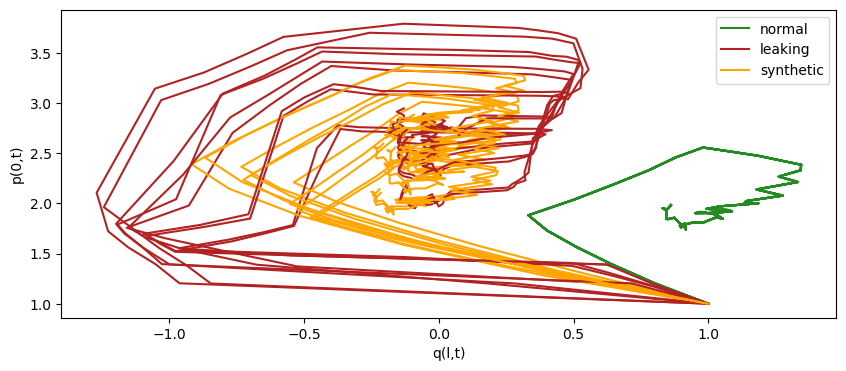

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 4), sharex=True)

for i in range(1, 10):
    ax.plot(ql0[:,i], p00[:,i], color='forestgreen')
    ax.plot(qld[:,i], p0d[:,i], color='firebrick')
    ax.plot(ql0[:,i] + ql_diff[:,i], p00[:,i] + p0_diff[:,i], color='orange')

# Plot the first line of each group with a label
ax.plot(ql0[:,0], p00[:,0], label='normal', color='forestgreen')
ax.plot(qld[:,0], p0d[:,0], label='leaking', color='firebrick')
ax.plot(ql0[:,0] + ql_diff[:,0], p00[:,0] + p0_diff[:,0], label='synthetic', color='orange')

ax.set_xlabel('q(l,t)')
ax.set_ylabel('p(0,t)')

ax.legend()
plt.show()


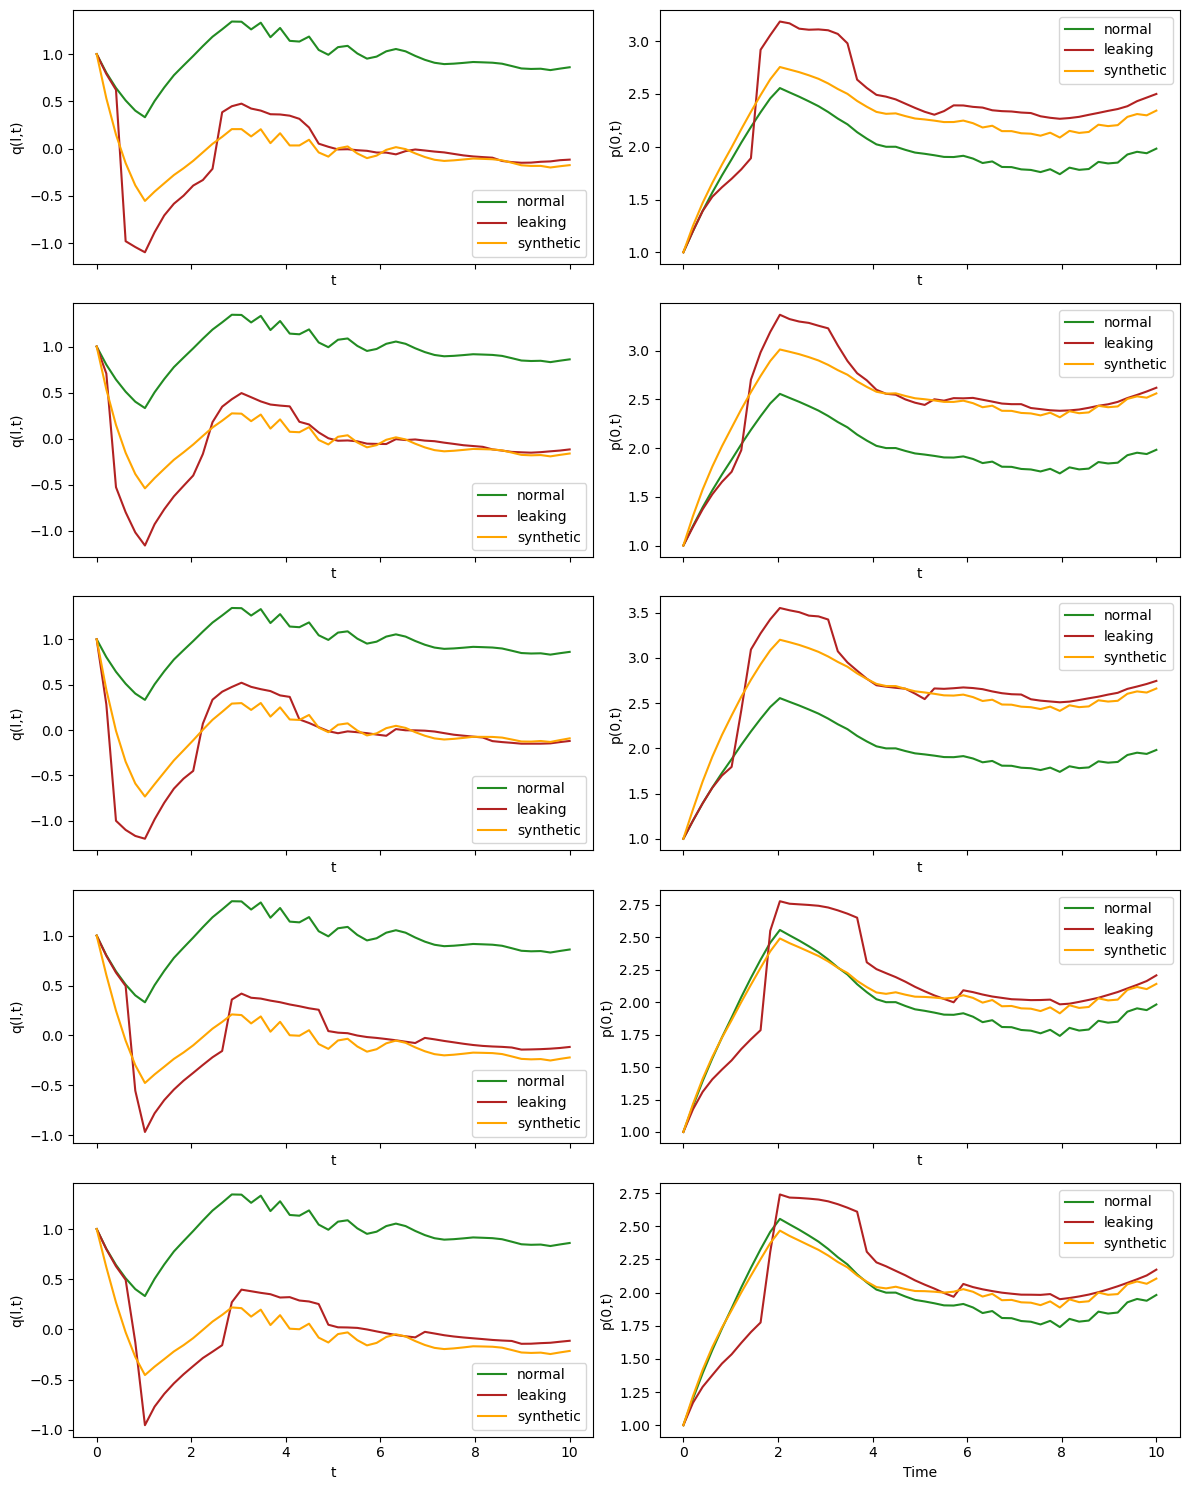

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 2, figsize=(12, 15), sharex=True)  # 10 rows, 2 columns
fig.subplots_adjust(hspace=0.4)

for i in range(5):
    ax_q = axs[i, 0]
    ax_p = axs[i, 1]
    
    
    ax_q.plot(sol_0.t, ql0[:, i], label='normal', color='forestgreen')
    ax_q.plot(sol_0.t, qld[:, i], label='leaking', color='firebrick')
    ax_q.plot(sol_0.t, ql0[:, i] + ql_diff[:, i], label='synthetic', color='orange')
    ax_q.set_ylabel(f'q(l,t)')
    ax_q.set_xlabel(f't')
    ax_q.legend()

    ax_p.plot(sol_0.t, p00[:, i], label='normal', color='forestgreen')
    ax_p.plot(sol_0.t, p0d[:, i], label='leaking', color='firebrick')
    ax_p.plot(sol_0.t, p00[:, i] + p0_diff[:, i], label='synthetic', color='orange')
    ax_p.set_ylabel(f'p(0,t)')
    ax_p.set_xlabel(f't')
    ax_p.legend()
    
    # ax_phase.plot(ql0[:, i], p00[:, i], label='normal')
    # ax_phase.plot(qld[:, i], p0d[:, i], label='leaking')
    # ax_phase.plot(ql0[:, i] + ql_diff[:, i], p00[:, i] + p0_diff[:, i], label='synthetic')
    # ax_phase.legend()

plt.xlabel('Time')
plt.tight_layout()
plt.show()


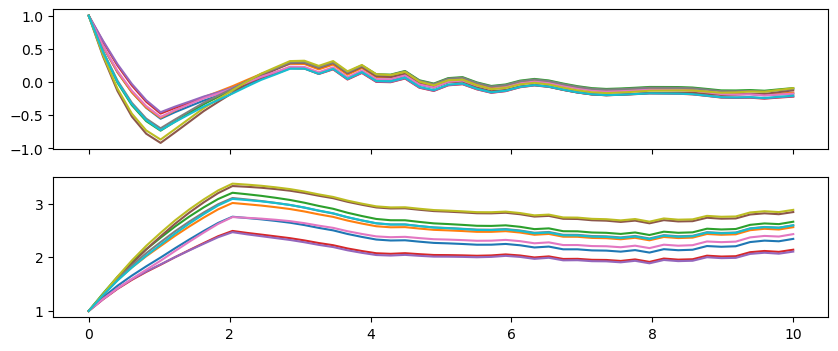

In [ ]:
N = sol_0.y.shape[0] // 2

ql_0 = sol_0.y[N-1,:]
p0_0 = sol_0.y[N,:]

ql_d = sol_d.y[N-1,:]
p0_d = sol_d.y[N,:]

fig, axs = plt.subplots(2, 1, figsize=(10, 4), sharex=True)

# axs[0].plot(sol_0.t, ql0, label='normal')
# axs[0].plot(sol_0.t, qld, label='leaking')

# axs[1].plot(sol_0.t, p00, label='normal')
# axs[1].plot(sol_0.t, p0d, label='leaking')

axs[0].plot(sol_0.t, ql0 + ql_diff, label='synthetic')
axs[1].plot(sol_0.t, p00 + p0_diff, label='synthetic')
plt.show()

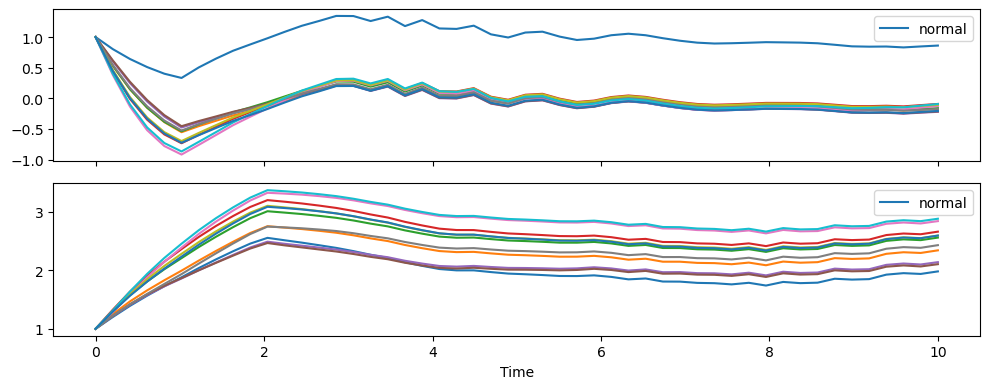

In [ ]:
import matplotlib.pyplot as plt

fig.subplots_adjust(hspace=0.4)

fig, ax = plt.subplots(2, 1, figsize=(10, 4), sharex=True)


ax[0].plot(sol_0.t, ql0[:,0], label='normal')
ax[0].plot(sol_0.t, ql0 + ql_diff)
ax[0].legend()

ax[1].plot(sol_0.t, p00[:,0], label='normal')
ax[1].plot(sol_0.t, p00 + p0_diff)
ax[1].legend()

plt.xlabel('Time')
plt.tight_layout()
plt.show()
